In [1]:
from DETR_model import DinoDetrMaskMul
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset, DAVIS_Infer, DAVIS_Dataset
import logging
import json
from tenLoader import normalize

In [2]:
model_name = "DETR_davis_mb"
model = DinoDetrMaskMul(mul_before=True).cuda()
model_path = f"./model/{model_name}_best.pth"
train_loss_dict_path = f"./log/{model_name}_loss.json"
train_iou_dict_path = f"./log/{model_name}_train_iou.json"
val_iou_dict_path = f"./log/{model_name}_val_iou.json"
log_path = f"./log/{model_name}.log"


Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
with open(train_loss_dict_path, "r") as f:
    train_loss_dict = json.load(f)
with open(train_iou_dict_path, "r") as f:
    train_iou_dict = json.load(f)
with open(val_iou_dict_path, "r") as f:
    val_iou_dict = json.load(f)

In [4]:
def numericalize_dict(d: dict):
    result = {}
    for key, value in d.items():
        result[int(key)] = float(value)
    return result
train_loss_dict = numericalize_dict(train_loss_dict)
train_iou_dict = numericalize_dict(train_iou_dict)
val_iou_dict = numericalize_dict(val_iou_dict)

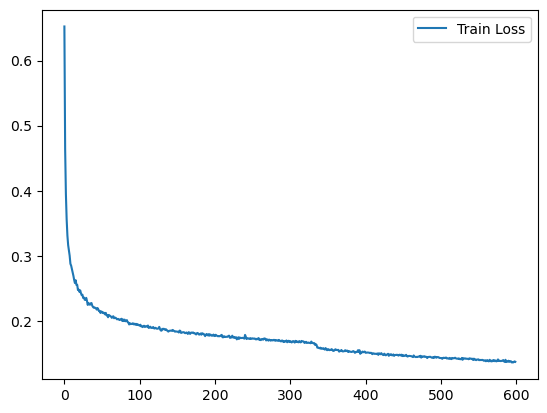

In [5]:
# plot the loss
plt.plot(
    list(train_loss_dict.keys()),
    list(train_loss_dict.values()),
    label="Train Loss",
)
plt.legend()
plt.show()

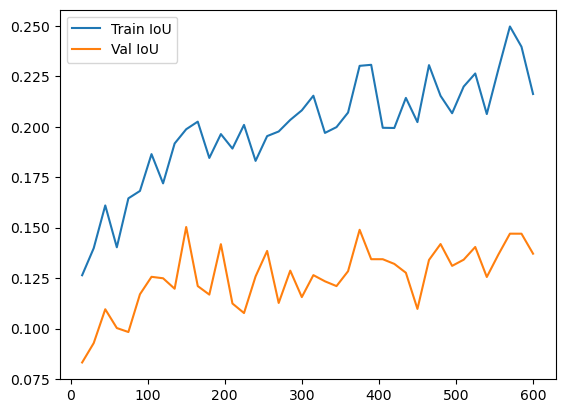

In [6]:
# plot the iou
plt.plot(
    list(train_iou_dict.keys()),
    list(train_iou_dict.values()),
    label="Train IoU",
)
plt.plot(
    list(val_iou_dict.keys()),
    list(val_iou_dict.values()),
    label="Val IoU",
)
plt.legend()
plt.show()

In [7]:
# load the model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [8]:
# train infer
train_raw_set = DAVIS_Rawset(is_train=True)
train_infer = DAVIS_Infer(train_raw_set)
# val infer
val_raw_set = DAVIS_Rawset(is_train=False)
val_infer = DAVIS_Infer(val_raw_set)

In [9]:
train_infer.infer_model(model)
val_infer.infer_model(model)
train_infer.get_total_iou(), val_infer.get_total_iou()

(0.19874231812438206, 0.15033565277305824)

In [10]:
train_infer.best_video_index

80

In [11]:
def find_best_video_index(infer: DAVIS_Infer, exclude: list):
    best_iou = 0
    best_index = -1
    for i in range(len(infer.raw_set.data_set)):
        if i in exclude:
            continue
        iou = infer.get_video_iou(i)
        if iou > best_iou:
            best_iou = iou
            best_index = i
    return best_index
find_best_video_index(train_infer, [80])

143

In [12]:
train_infer.get_video_iou(143)

0.8163402041150254

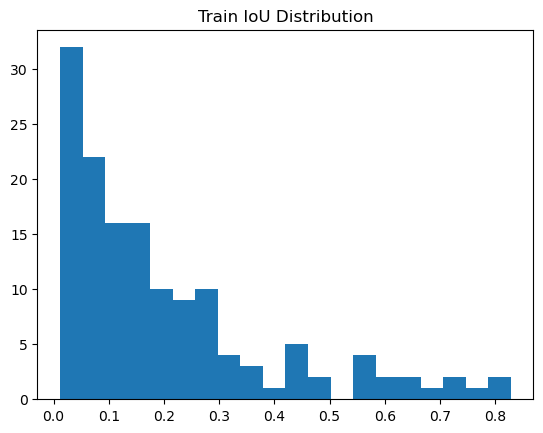

In [13]:
# plot the iou distribution
def plot_iou_distribution(
    infer: DAVIS_Infer,
    title: str = "IoU Distribution",
):
    iou_list = []
    for i in range(len(infer.raw_set.data_set)):
        iou = infer.get_video_iou(i)
        iou_list.append(iou)
    plt.hist(iou_list, bins=20)
    plt.title(title)
    plt.show()


plot_iou_distribution(train_infer, "Train IoU Distribution")

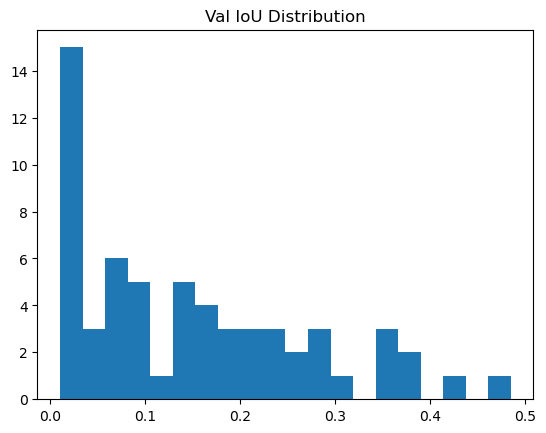

In [14]:
plot_iou_distribution(val_infer, "Val IoU Distribution")

In [15]:
val_infer.get_total_iou()

0.15033565277305824

In [16]:
val_infer.get_video_iou(val_infer.worst_video_index)

0.010101010101010102

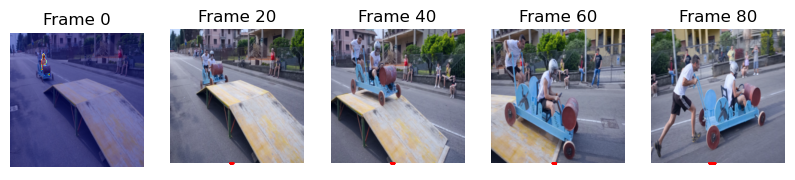

In [26]:
val_infer.show_infer_results(
    val_infer.worst_video_index,
    figsize=(10, 5),
    interval=20,
)

In [18]:
train_infer.get_video_iou(train_infer.worst_video_index)

0.011627906976744186

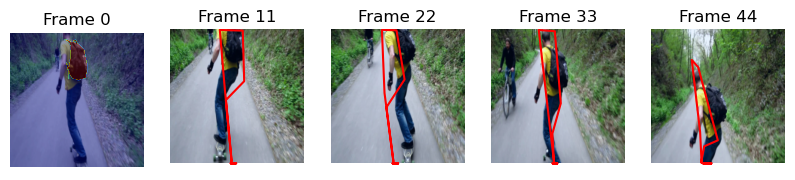

In [29]:
train_infer.show_infer_results(
    70,
    figsize=(10, 5),
    interval=11,
)

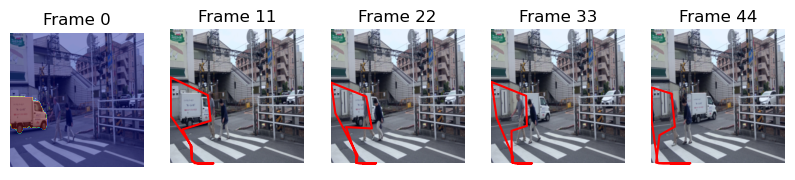

In [39]:
train_infer.show_infer_results(
    20,
    figsize=(10, 5),
    interval=11,
)

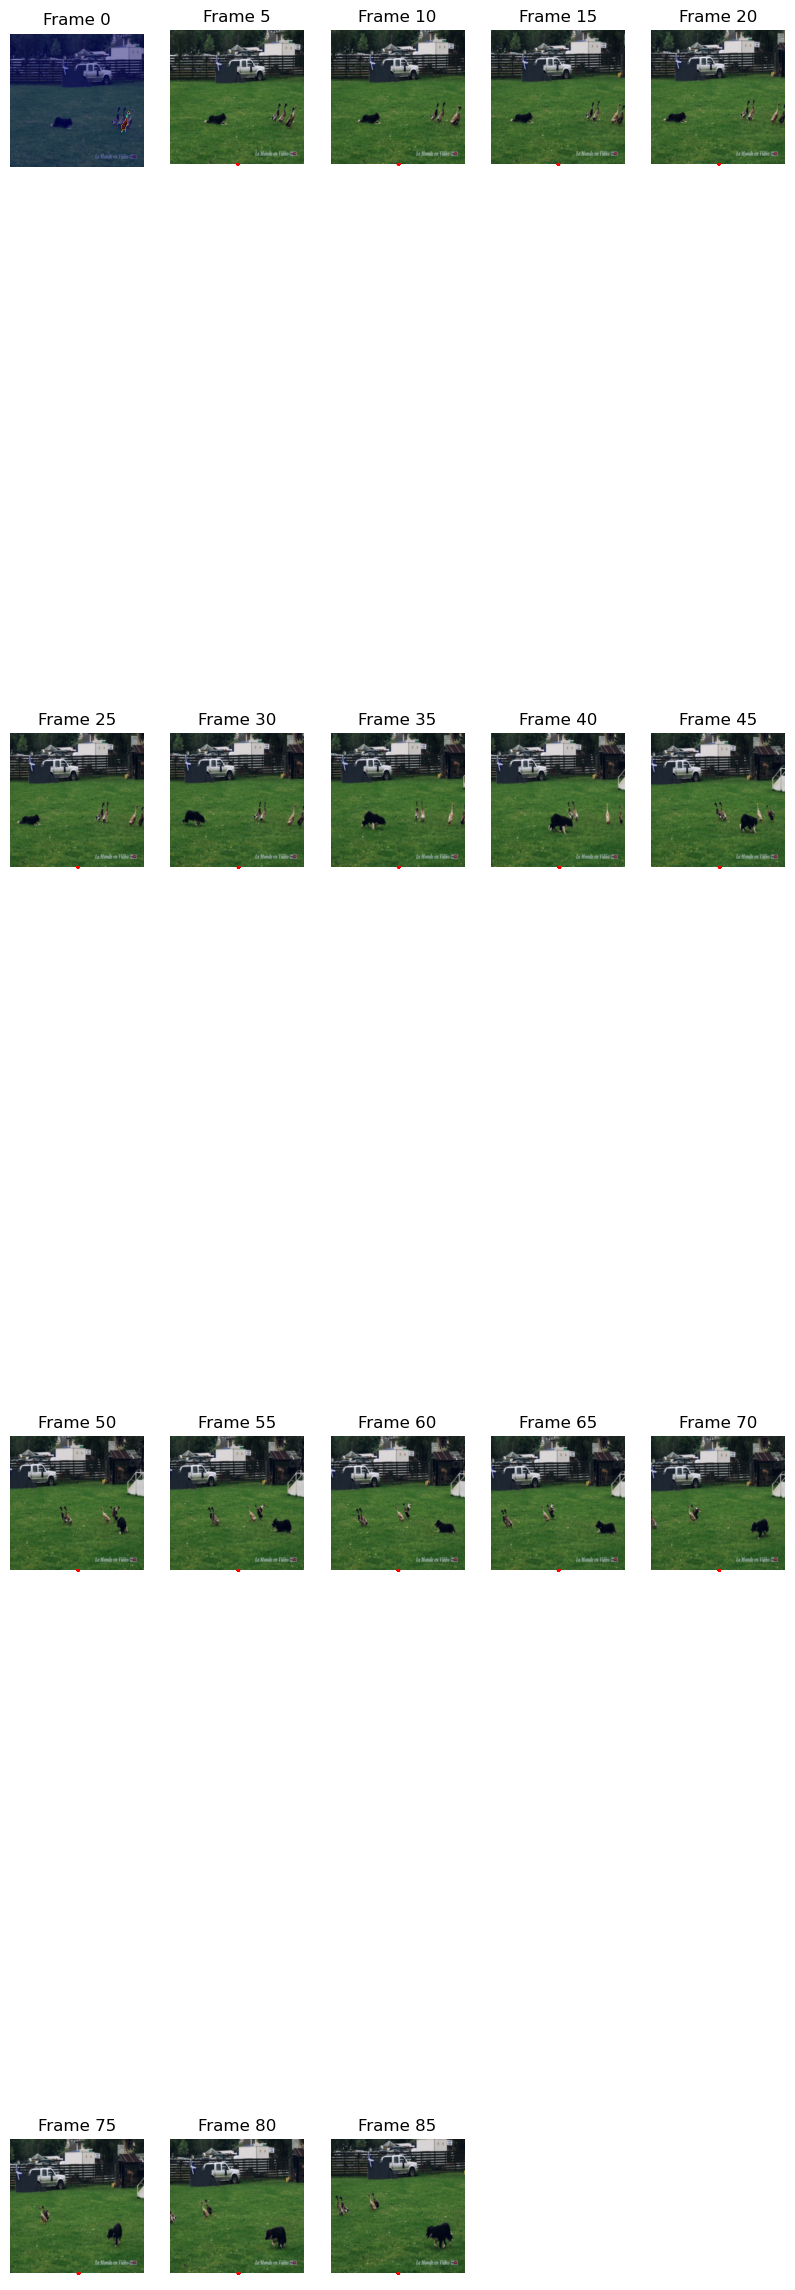

In [20]:
train_infer.show_infer_results(train_infer.worst_video_index)

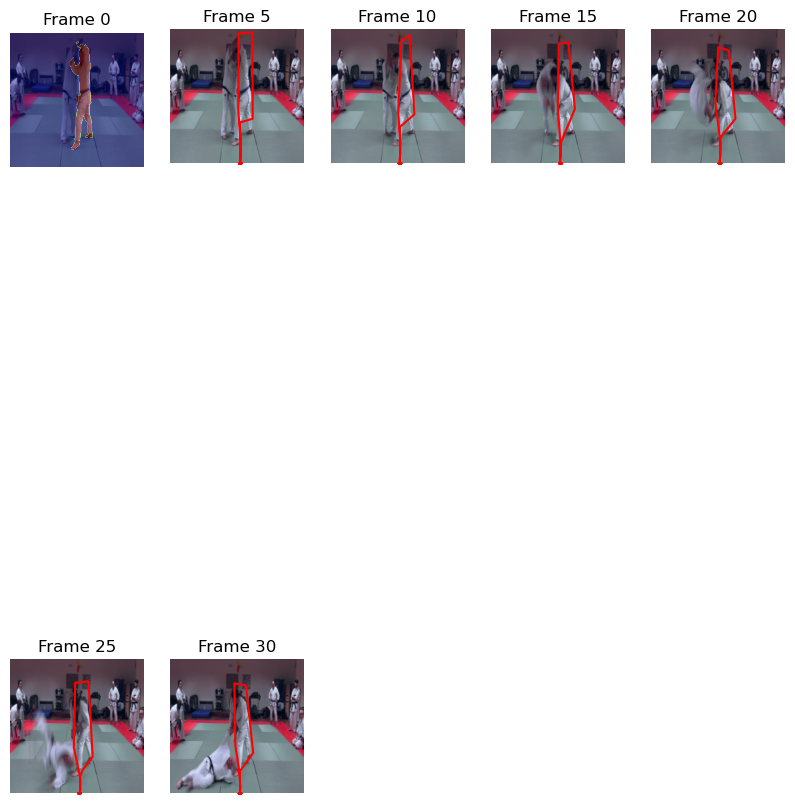

In [21]:
val_infer.show_infer_results(
    val_infer.best_video_index,
    figsize=(10, 15),
)

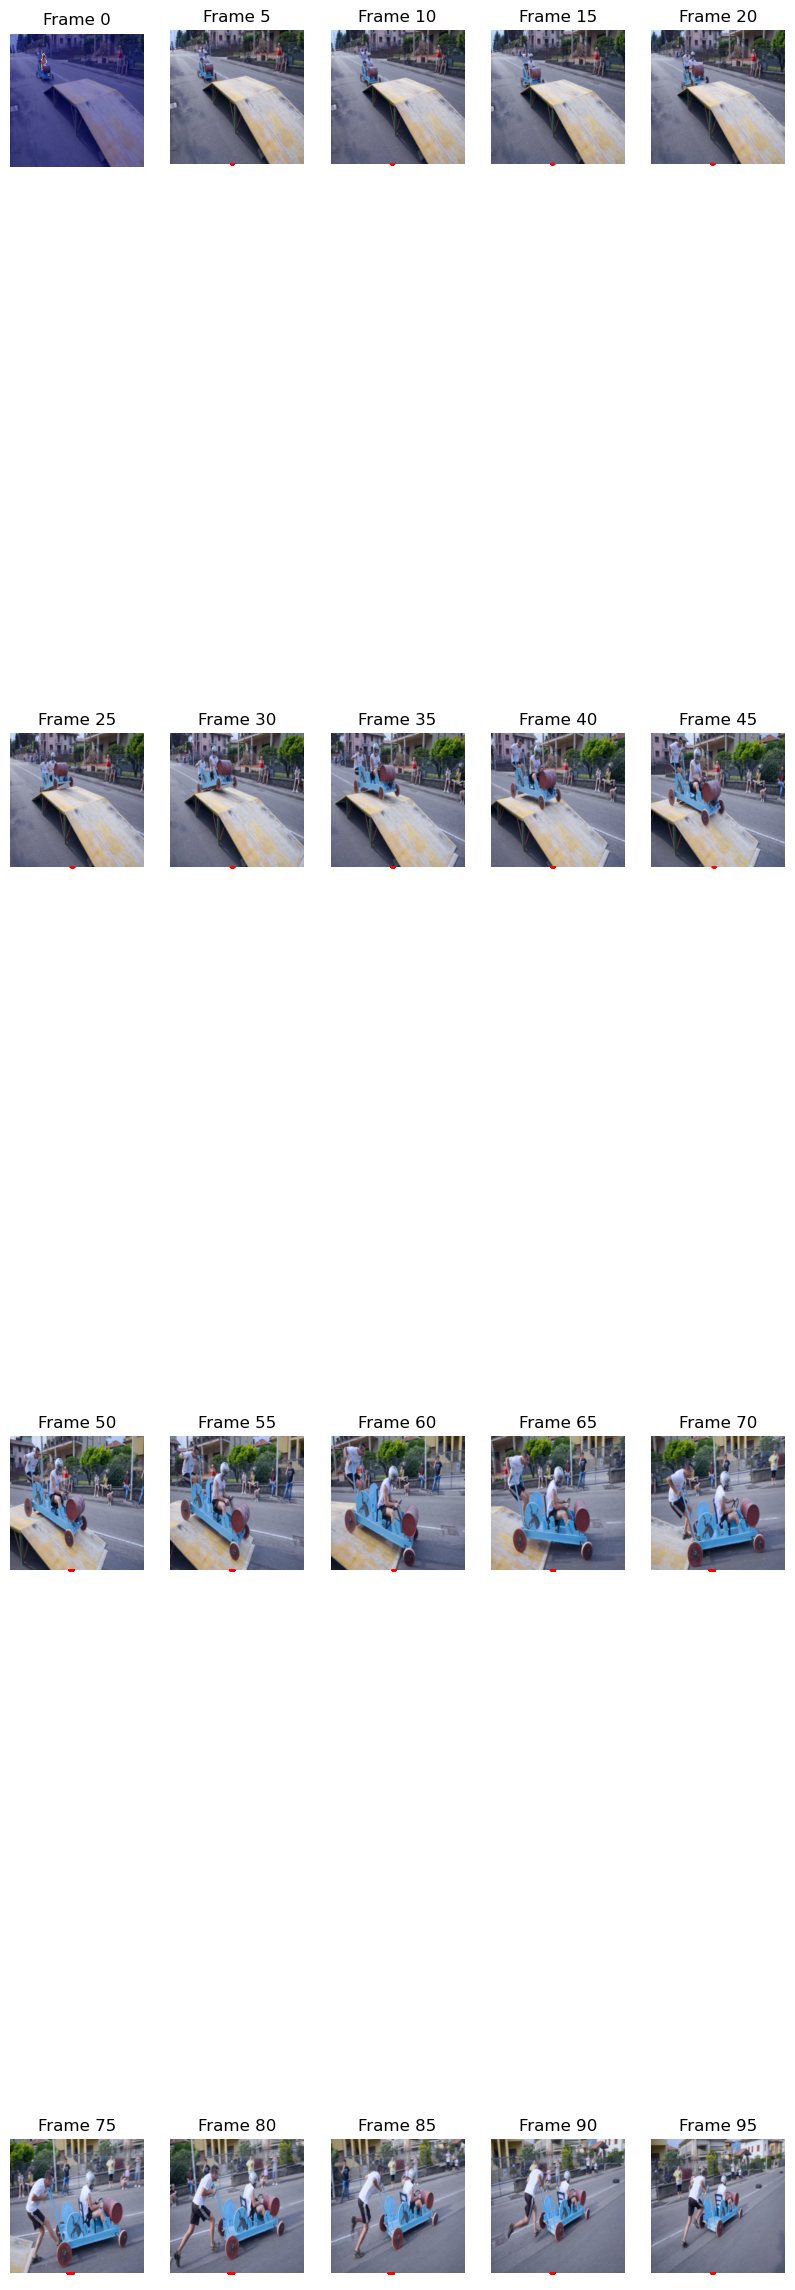

In [22]:
val_infer.show_infer_results(val_infer.worst_video_index)